# 3D pharmacophores in the rdkit

The RDKit features functionality to align molecules to pharmacophoric features in 3D. This can be used for a simple alignment as well as for a fast pharmacophore searching. Pharmcacophore features are based on so-called feature factories ( a sample file "BaseFeatures.fdef" can be found in the Data directory ). 

The method is a three step procedure:
1. conversion of the 3D pharmacophore to a boundary matrix
2. matching of the pharmacophore to the boundary matrix of the target molecule using triangle smoothing
3. embedding of the molecule to the pharmacophore using distance geometry (UFF force field)

Here, we provide some guidance on how to use the 3D pharmacophore tools in the RDKit based on an example. We will create a pharmacophore from an ALK5 kinase crystal structure (PDB:1PY5) and will show how to align a sample structures extracted from the crystal structure.

In the crystal structure, the main interaction patterns that can be identified are the hydrogen bonds between the ligand and H283 as well as the water W5 in the backpocket. In both cases the ligand interacts as an H-bond acceptor. In addition, there is a weak H-bond donor functionality interacting with D351. Apart from the directional interactions the ligand has aromatic interactions with its chinoline as well as the backpocket pyridine.

![ALK5 1PY5 binding mode](images/kinaseOverview.png)

Based on that information we can now start setting up a pharmacophore (ph4)

In [1]:
from __future__ import print_function
from rdkit import RDConfig, Chem, Geometry, DistanceGeometry
from rdkit.Chem import ChemicalFeatures, rdDistGeom, Draw, rdMolTransforms
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Chem.Draw import IPythonConsole, DrawingOptions
from rdkit.Numerics import rdAlignment

### Setting up a pharmacophore

In the RDkit a pharmacophore is defined by an object with a set of free chemical features (like acceptors, donors etc.) and a boundary matrix that describes the location of the features with respect to each other. One can define such a pharmacophore object manually.

In [2]:
import os.path
fdef = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdef)
samplePh4Feats = [ChemicalFeatures.FreeChemicalFeature('Acceptor', Geometry.Point3D(3.877, 7.014, 1.448)),
            ChemicalFeatures.FreeChemicalFeature('Acceptor', Geometry.Point3D(7.220, 11.077, 5.625)),
            ChemicalFeatures.FreeChemicalFeature('Acceptor', Geometry.Point3D(4.778, 8.432, 7.805))]
samplePcophore = Pharmacophore.Pharmacophore(samplePh4Feats)

In [3]:
samplePcophore._boundsMat

array([[ 0.        ,  6.71795706,  6.57525467],
       [ 6.71795706,  0.        ,  4.20853763],
       [ 6.57525467,  4.20853763,  0.        ]])

When applied in drug discovery projects, pharmacophore features are usually described as fuzzy locations in space. To describe this kind of fuzziness it is possible to manually change the lower and upper bounds of the respective points in the pharmacophore boundary matrix. 

In [4]:
samplePcophore.setLowerBound(0,1,6.0)
samplePcophore.setUpperBound(0,1,7.0)
samplePcophore.setLowerBound(0,2,6.0)
samplePcophore.setUpperBound(0,2,7.0)
samplePcophore.setLowerBound(1,2,3.5)
samplePcophore.setUpperBound(1,2,5.0)

In [5]:
samplePcophore._boundsMat

array([[ 0. ,  7. ,  7. ],
       [ 6. ,  0. ,  5. ],
       [ 6. ,  3.5,  0. ]])

However, mostly end users will describe a three dimensional pharmacophore using a graphical interface and then write out the details to a flat file. Here, we will show an application of this using a pharmacophore (based on the above) created using MOE.

In [6]:
moePh43Point = """#moe:ph4que 2014.09
#pharmacophore 7 tag t value *
scheme t Unified matchsize i 0 use_Hs i 1 abspos i 0 title t $ useRval i 0 comment s $
#feature 3 expr tt color ix x r y r z r r r ebits ix gbits ix m ix
Acc df2f2 3.877 7.014 1.448 0.3 0 400 a64cff 
Acc df2f2 7.22 11.077 5.625 0.3 0 400 a64cff 
Don f20df2 4.778 8.432 7.805 0.3 0 400 a64cff
#endpharmacophore"""

In [7]:
moePh43Point.split("\n")

['#moe:ph4que 2014.09',
 '#pharmacophore 7 tag t value *',
 'scheme t Unified matchsize i 0 use_Hs i 1 abspos i 0 title t $ useRval i 0 comment s $',
 '#feature 3 expr tt color ix x r y r z r r r ebits ix gbits ix m ix',
 'Acc df2f2 3.877 7.014 1.448 0.3 0 400 a64cff ',
 'Acc df2f2 7.22 11.077 5.625 0.3 0 400 a64cff ',
 'Don f20df2 4.778 8.432 7.805 0.3 0 400 a64cff',
 '#endpharmacophore']

First we need to parse the MOE ph4 content and then convert it into something useful for the RDKit (a pharmacophore object)

In [8]:
#########################
# parse the ph4 content #
#########################
def parsePh4Content(moePh4List):
  ph4Info = {}
  header = []
  content = []
  for line in moePh4List.split("\n"):
    if line[0] == "#":
      if len(header) > 0:
        ph4Info[header[0]] = (header,content)
        header = []
        content = []
      header = line.strip().split()
    else:
      content.extend(line.strip().split())
  return ph4Info

############################    
# convert the feature info #
############################
def convertFeatureInfo(ph4InfoDict):
  feats = []
  radii=[]
  # this is the conversion of the moe ph4 nomenclature to the rdkit one
  moePh4Conv = {"Acc":"Acceptor","Don":"Donor","Aro":"Aromatic","Hyd":"Hydrophobe"}  
  header,content = ph4InfoDict['#feature']
  noFeats = int(header[1])
  lenSingleFeature = int((len(header)/2)-1)
  # loop over ph4 features and populate pharmacophore object
  for i in range(noFeats):
    featFamily = content[(lenSingleFeature*i)]
    (x,y,z) = (float(content[(lenSingleFeature*i)+2]),float(content[(lenSingleFeature*i)+3]),
               float(content[(lenSingleFeature*i)+4]))
    r = float(content[(lenSingleFeature*i)+5])
    feats.append(ChemicalFeatures.FreeChemicalFeature(moePh4Conv[featFamily],Geometry.Point3D(x,y,z)))
    radii.append(r)
  return (feats,radii)


In [9]:
############################
# create the pharmacophore #
############################
ph4Info = parsePh4Content(moePh43Point)
feats,radii = convertFeatureInfo(ph4Info)
pcophore = Pharmacophore.Pharmacophore(feats)

Now that we have the pharmacophore object created we need to modfy the bounds matrix to incorporate the radii of the various ph4 features. For this, we set the respective lower and upper boundaries in the bounds matrix of the pharmacophore object. For this we calculate the distance between the features and subtract (lower bounds) or add (upper bounds) the summ of the respective feature radii (see image).

![MOE PH4 distance example](images/1py5Ph4DistancesOrig.png)

For example, the distance between F1:Acc and F2:Acc is 6.72 Angstrom and the corresponding feature radii are 1.0 Angstrom each. So, in order to include the fuzziness of the pharmacophores the lower bounds are then set to max(featureDistance-(F1Radii+F2Radii),0). The max() is here applied in order to avoid having negative bounds values. The same is done for the upper bounds only that in this case the same of the radii is added to the distance

![Fuzzy boundary matrix](images/1py5Ph4DistanceExample.png)

In [10]:
pcophore._boundsMat

array([[ 0.        ,  6.71795706,  6.57525467],
       [ 6.71795706,  0.        ,  4.20853763],
       [ 6.57525467,  4.20853763,  0.        ]])

In [11]:
def applyRadiiToBounds(radii,pcophore):
  for i in range(len(radii)):
    for j in range(i+1,len(radii)):
      sumRadii = radii[i]+radii[j]
      pcophore.setLowerBound(i,j,max(pcophore.getLowerBound(i,j)-sumRadii,0))
      pcophore.setUpperBound(i,j,pcophore.getUpperBound(i,j)+sumRadii)
applyRadiiToBounds(radii,pcophore)

In [12]:
pcophore._boundsMat

array([[ 0.        ,  7.31795706,  7.17525467],
       [ 6.11795706,  0.        ,  4.80853763],
       [ 5.97525467,  3.60853763,  0.        ]])

### Checking a molecule against a pharmacophore

The RDKit provides a simple method to check a pharmacophore against a molecule. The idea of this is to filter out quickly molecules for which an embedding is not possible. Essentially, the molecule is analyzed for its pharmacophoric features and those are checked against the features of the pharmacophore. The output is a boolean indicating whether or not the molecule can fulfill the pharmacophore purely based on its features as well as a list of all possible mappings of the pharmacophore to the molecule.

In [13]:
ligand = Chem.MolFromSmiles("c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1")

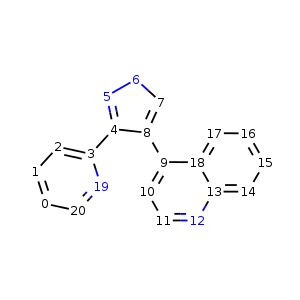

In [14]:
DrawingOptions.bondLineWidth=1.8
DrawingOptions.atomLabelFontSize=14
DrawingOptions.includeAtomNumbers=True
Draw.MolToImage(ligand,options=DrawingOptions)

In [15]:
canMatch,allMatches = EmbedLib.MatchPharmacophoreToMol(ligand,featFactory,pcophore) 

In [16]:
canMatch

True

In [17]:
for (i,match) in enumerate(allMatches):
  for f in match:
    print("%d %s %s %s"%(i, f.GetFamily(), f.GetType(), f.GetAtomIds()))

0 Acceptor SingleAtomAcceptor (5,)
0 Acceptor SingleAtomAcceptor (12,)
0 Acceptor SingleAtomAcceptor (19,)
1 Acceptor SingleAtomAcceptor (5,)
1 Acceptor SingleAtomAcceptor (12,)
1 Acceptor SingleAtomAcceptor (19,)
2 Donor SingleAtomDonor (5,)
2 Donor SingleAtomDonor (6,)


### Matching a molecule to a pharmacophore

Since the RDKit pharmacophore module is based on distance geometry, a molecule can be matched to a pharmacophore without actually aligning it to the pharmacophore. For this, the molecules' (smoothed) bounds matrix is updated with the distances of the pharmacophore bounds at the respective atom matches. Then, the algorithm tries to smooth the modified bounds matrix. 

In [18]:
boundsMat = rdDistGeom.GetMoleculeBoundsMatrix(ligand)

In [19]:
if canMatch:
  failed,boundsMatMatched,matched,matchDetails = EmbedLib.MatchPharmacophore(allMatches,boundsMat,
                                                                             pcophore,useDownsampling=False)

Apart from an indicator if the molecule could be matched to the pharmacophore (failed), a lot of useful information is returned. The molecules' smoothed bounds matrix (boundsMatMatched) as well as information of what atoms were matched to the pharmacophore (matched).

In [20]:
failed

0

In [21]:
boundsMatMatched.shape

(21, 21)

In [22]:
for match in matched:
  print("%s %d"%(match.GetFamily(),match.GetAtomIds()[0]))

Acceptor 12
Acceptor 19
Donor 5


Computation times of bounds smoothing depend heavily on the size of the bounds matrix. To speed up things, the RDKit provides an argument to the MatchPharmacophore method (useDownsampling) which essentially reduces the bounds matrix to the relevant elements and then does the bounds smoothing on the reduced matrix. The matchDetails return value is a tuple that provides information on the size of the input bounds matrix as well as the output bounds matrix. If downsampling is not enabled both values are identical if not they differ where the second element is the reduced bounds matrix size.

In [23]:
matchDetails

(21, 21)

In [24]:
failed,boundsMatMatched,matched,matchDetails = EmbedLib.MatchPharmacophore(allMatches,boundsMat,
                                                                           pcophore,useDownsampling=True)

In [25]:
failed

0

In [26]:
matchDetails

(21, 13)

### Embedding a molecule onto a pharmacophore ( NOT the actual alignment)

Now that we know that the molecule should actually embed onto the pharmacophore and how (using the list of matches returned from MatchPharmacophore), embedding the molecule (with the ph4 constraints) is actually quite straightforward.

In [27]:
atomMatch = [list(x.GetAtomIds()) for x in matched]

In [28]:
atomMatch

[[12], [19], [5]]

In [29]:
bm,embeddings,numFail = EmbedLib.EmbedPharmacophore(ligand,atomMatch,pcophore,count=10)

In [30]:
numFail

0

In [31]:
len(embeddings)

10

In this case none of the embeddings failed. Note - at this stage the molecule is just embedded onto the pharmacophore and not aligned to it. 

### Aligning an embedding to a pharmacophore

In order to do the the alignment code provided by the RDKit can be used. First we start by generating the coordinates of the matching pharmacophoric points - since this can be multiple points per match we cannot just use the atomIds and do the alignment based on that. For this, we create the geometric mean of the multiple atoms coordinates and use that to align to the pharmacophore features. 

In [32]:
def GetTransformMatrix(alignRef,confEmbed,atomMatch):
  alignProbe = []
  for matchIds in atomMatch:
    dummyPoint = Geometry.Point3D(0.0,0.0,0.0)
    for id in matchIds:
      dummyPoint += confEmbed.GetAtomPosition(id)
    dummyPoint /= len(matchIds)
    alignProbe.append(dummyPoint)
  return (rdAlignment.GetAlignmentTransform(alignRef,alignProbe))

def TransformEmbeddings(pcophore,embeddings,atomMatch):
  alignRef = [f.GetPos() for f in pcophore.getFeatures()]
  SSDs = []
  for embedding in embeddings:
    conf = embedding.GetConformer()
    SSD,transformMatrix = GetTransformMatrix(alignRef,conf,atomMatch)
    rdMolTransforms.TransformConformer(conf,transformMatrix)
    SSDs.append(SSD)
  return(SSDs)

TransformEmbeddings(pcophore,embeddings,atomMatch)

[0.3321247112609953,
 0.3236217084447972,
 0.32269825992559475,
 0.32268316262663177,
 0.3375870339269582,
 0.3274337024544991,
 0.34295635393173285,
 0.3197867028216379,
 0.327922173155347,
 0.32504453049968873]

All alignments seem to work pretty well (low squared deviation values). This is also true when looking at how the pharmacophoric features of the lgand fit the pharmacophoric query.

![Aligned Embeddings](images/alignEmbed3Point.png)

Unfortunately the query wasn't setup very well with respect to "fixing" the molecules. I.e. the chinoline as well as the backpocket pyridine binding moiety are spread all over 3D space. This can be improved by a modified query that now also contains an additional aromatic feature next to the hinge binder.

![4point ph4](images/1py5Ph44pointph4InPocket.png)

Running the same alignment as above ...

In [33]:
moePh44Point = """#moe:ph4que 2014.09
#pharmacophore 7 tag t value *
scheme t Unified matchsize i 0 use_Hs i 1 abspos i 0 title t $ useRval i 0 comment s $
#feature 4 expr tt color ix x r y r z r r r ebits ix gbits ix m ix
Acc df2f2 3.877 7.014 1.448 0.3 0 400 a64cff 
Acc df2f2 7.22 11.077 5.625 0.3 0 400 a64cff 
Don f20df2 4.778 8.432 7.805 0.3 0 400 a64cff 
Aro ff8000 1.56433333333334 7.06399999999999 3.135 1.5 0 400 a64cff
#endpharmacophore"""


In [34]:
ph4Info = parsePh4Content(moePh44Point)
feats,radii = convertFeatureInfo(ph4Info)
pcophore = Pharmacophore.Pharmacophore(feats)
applyRadiiToBounds(radii,pcophore)
ligand = Chem.MolFromSmiles("c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1")
boundsMat = rdDistGeom.GetMoleculeBoundsMatrix(ligand)
canMatch,allMatches = EmbedLib.MatchPharmacophoreToMol(ligand,featFactory,pcophore)
if canMatch:
  failed,boundsMatMatched,matched,matchDetails = EmbedLib.MatchPharmacophore(allMatches,boundsMat,
                                                                             pcophore,useDownsampling=True)
atomMatch = [list(x.GetAtomIds()) for x in matched]
bm,embeddings,numFail = EmbedLib.EmbedPharmacophore(ligand,atomMatch,pcophore,count=10)
TransformEmbeddings(pcophore,embeddings,atomMatch)

[7.915173223555158,
 4.7842546333541165,
 0.6788058133483901,
 2.5692061536218915,
 5.28204553473288,
 0.8071252628471228,
 11.540427927405645,
 4.842962525686893,
 14.092063643281953,
 3.6936373819687915]

Adding constraints into the embedding clearly worsens the SSD values for many alignments. Put differently, even though the distance matrix allows the ph4 to be fit when the actual matching in 3D space happens only few of the matches can be properly embedded onto the pharmacophore. Still, for example alignment 3 shows a low SSD value and the actual alignment looks good.

![Alignment 3](images/4PointAlignment3.png)

Note that in this match the H-Bond donor is matched to the pyrazol nitrogen without the hydrogen atom. This is due to the definitions in the BaseFeatures.fdef file and is due to the potential tautomerism of the pyrazole group. 
This is what we would get if we "cheat" the second donor atom away (note that the first full match of the pharmacophore feature mappings is used in the embedding). We could also achieve the same by changing the definitions of the BaseFeatures file but this is easier for now.

In [35]:
for (i,match) in enumerate(allMatches):
  for f in match:
    print("%d %s %s %s"%(i, f.GetFamily(), f.GetType(), f.GetAtomIds()))

0 Acceptor SingleAtomAcceptor (5,)
0 Acceptor SingleAtomAcceptor (12,)
0 Acceptor SingleAtomAcceptor (19,)
1 Acceptor SingleAtomAcceptor (5,)
1 Acceptor SingleAtomAcceptor (12,)
1 Acceptor SingleAtomAcceptor (19,)
2 Donor SingleAtomDonor (5,)
2 Donor SingleAtomDonor (6,)
3 Aromatic Arom5 (4, 5, 6, 7, 8)
3 Aromatic Arom6 (0, 1, 2, 3, 19, 20)
3 Aromatic Arom6 (9, 10, 11, 12, 13, 18)
3 Aromatic Arom6 (13, 14, 15, 16, 17, 18)


In [36]:
allMatches[2] = (allMatches[2][1],)

In [37]:
for (i,match) in enumerate(allMatches):
  for f in match:
    print("%d %s %s %s"%(i, f.GetFamily(), f.GetType(), f.GetAtomIds()))

0 Acceptor SingleAtomAcceptor (5,)
0 Acceptor SingleAtomAcceptor (12,)
0 Acceptor SingleAtomAcceptor (19,)
1 Acceptor SingleAtomAcceptor (5,)
1 Acceptor SingleAtomAcceptor (12,)
1 Acceptor SingleAtomAcceptor (19,)
2 Donor SingleAtomDonor (6,)
3 Aromatic Arom5 (4, 5, 6, 7, 8)
3 Aromatic Arom6 (0, 1, 2, 3, 19, 20)
3 Aromatic Arom6 (9, 10, 11, 12, 13, 18)
3 Aromatic Arom6 (13, 14, 15, 16, 17, 18)


In [38]:
ligand = Chem.MolFromSmiles("c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1")
boundsMat = rdDistGeom.GetMoleculeBoundsMatrix(ligand)
failed,boundsMatMatched,matched,matchDetails = EmbedLib.MatchPharmacophore(allMatches,boundsMat,
                                                                           pcophore,useDownsampling=True)
atomMatch = [list(x.GetAtomIds()) for x in matched]
bm,embeddings,numFail = EmbedLib.EmbedPharmacophore(ligand,atomMatch,pcophore,count=10)
TransformEmbeddings(pcophore,embeddings,atomMatch)

[9.449900893262338,
 12.608272483126797,
 8.076938522573315,
 12.26674023114839,
 8.467141387356321,
 1.1167183122471869,
 10.33837665309676,
 2.8690516647350535,
 13.664258269388334,
 2.9510680148696338]

In this case, alignment 6 shows a good SSD value which is also reflected by a good alignment (this time with the correct Donor alignment).

![Donor alignment](images/4PointAlignmentCheat6.png)

# Caveat !!

One of the next steps could be to completely "pin down" the ph4 so that the compound really fits the ph4. In order to do that, the backpocket pyridine would need to be brought into plane with the rest of the molecule. To achieve that, the aromatic ph4 feature needs to be included. 
This is where things can get tricky ... in this case the acceptor feature of the pyridine ring system is also part of the aromatic system which means that during the bounds smoothing process an interference between the two will hinder a positive matching. 

In [39]:
moePh45Point = """#moe:ph4que 2014.09
#pharmacophore 7 tag t value *
scheme t Unified matchsize i 0 use_Hs i 1 abspos i 0 title t $ useRval i
0 comment s $
#feature 5 expr tt color ix x r y r z r r r ebits ix gbits ix m ix
Acc df2f2 3.877 7.014 1.448 1 0 400 a64cff 
Acc df2f2 7.22 11.077 5.625 1 0 400 a64cff 
Don f20df2 4.778 8.432 7.805 1 0 400 a64cff 
Aro ff8000 1.56433333333334 7.06399999999999 3.135 1 0 400 a64cff 
Aro ff8000 6.68983333333333 11.6213333333333 4.498 1 0 400 a64cff
#endpharmacophore"""

In [40]:
ph4Info = parsePh4Content(moePh45Point)
feats,radii = convertFeatureInfo(ph4Info)
pcophore = Pharmacophore.Pharmacophore(feats)
applyRadiiToBounds(radii,pcophore)
ligand = Chem.MolFromSmiles("c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1")
boundsMat = rdDistGeom.GetMoleculeBoundsMatrix(ligand)
canMatch,allMatches = EmbedLib.MatchPharmacophoreToMol(ligand,featFactory,pcophore)
if canMatch:
  failed,boundsMatMatched,matched,matchDetails = EmbedLib.MatchPharmacophore(allMatches,boundsMat,
                                                                             pcophore,useDownsampling=True)

In [41]:
failed

1

__When setting up ph4 queries, make sure that multi-atom pharmacophoric features do not include other pharmacophoric features!__ 

# Running over multiple molecules

Now that we have know how to align the co-crystallised ligand back to its pharmacophore query we can run a couple of molecules that should fit into the pocket of that target enzyme (here Ren et al. doi:10.1016/j.ejmech.2009.07.008). We use the first 5 molecules from the list of actives and use the 4-point pharmacophore used above but with a radius of 1.0.

In [42]:
moePh44Point = """#moe:ph4que 2014.09
#pharmacophore 7 tag t value *
scheme t Unified matchsize i 0 use_Hs i 1 abspos i 0 title t $ useRval i 0 comment s $
#feature 4 expr tt color ix x r y r z r r r ebits ix gbits ix m ix
Acc df2f2 3.877 7.014 1.448 1.0 0 400 a64cff 
Acc df2f2 7.22 11.077 5.625 1.0 0 400 a64cff 
Don f20df2 4.778 8.432 7.805 1.0 0 400 a64cff 
Aro ff8000 1.56433333333334 7.06399999999999 3.135 1.0 0 400 a64cff
#endpharmacophore"""

In [43]:
from operator import itemgetter
ph4Info = parsePh4Content(moePh44Point)
feats,radii = convertFeatureInfo(ph4Info)
pcophore = Pharmacophore.Pharmacophore(feats)
applyRadiiToBounds(radii,pcophore)
molSmiles = ['Cc1cccc(c2n[nH]cc2c3ccc4ncccc4n3)n1','Cc1cccnc1c2nc(N)sc2c3nc4cccnc4cc3',
             'Cc1cccc(c2[nH]c(CNc5cc(C(=O)N)ccc5)nc2c3ccc4nccnc4c3)n1','Clc1cccc(c2nc(N)sc2c3ccc4ncccc4n3)c1',
                 'n1ccccc1c2nn3CCCc3c2c4ccnc5cc(NC(=O)NCCN(C)C)ccc45']
mols = [Chem.MolFromSmiles(smi) for smi in molSmiles]
res = []
for i,mol in enumerate(mols):
  print(i)
  boundsMat = rdDistGeom.GetMoleculeBoundsMatrix(mol)
  canMatch,allMatches = EmbedLib.MatchPharmacophoreToMol(mol,featFactory,pcophore)
  if canMatch:
    failed,boundsMatMatched,matched,matchDetails = EmbedLib.MatchPharmacophore(allMatches,boundsMat,
                                                                               pcophore,useDownsampling=True)
    if failed:
      print("Couldn't embed molecule %d"%i)
      continue
  else:
    print("Couldn't match molecule %d"%i)
    continue
  atomMatch = [list(x.GetAtomIds()) for x in matched]
  try:
    bm,embeddings,numFail = EmbedLib.EmbedPharmacophore(mol,atomMatch,pcophore,count=10)
  except ValueError:
    print ("Bounds smoothing failed for molecule %d"%i)
    continue
  SSDs = TransformEmbeddings(pcophore,embeddings,atomMatch) 
  bestFitIndex = min(enumerate(SSDs), key=itemgetter(1))[0] 
  res.append((SSDs[bestFitIndex],embeddings[bestFitIndex]))

0
1
2
3
Couldn't embed molecule 3
4


In [44]:
res

[(4.054850312203385, <rdkit.Chem.rdchem.Mol at 0x7f9c02afe848>),
 (7.526851737029688, <rdkit.Chem.rdchem.Mol at 0x7f9c02afe490>),
 (3.4272400322304577, <rdkit.Chem.rdchem.Mol at 0x7f9c02afeae8>),
 (6.532335814958643, <rdkit.Chem.rdchem.Mol at 0x7f9c02afe458>)]

As one can see based on RMSD values, the overall alignment to the pharmacophore is not very good. This is also reflected when looking at how the molecules are aligned:

![multiMol alignment](images/4PointAlignmentAll.png)

Of course - this doesn't mean that the method itself is not good - it just shows that the molecules are not fitting the pharmacophore. The above example is merely there to show how to run the method on multiples molecules.
In addition it shows that one can use the basic alignment values in order to quickly remove molecules that do not properly fit the pharmacophore. However, be cautious since the conformations of the aligned molecules are not really good - but that's for another tutorial ... 